<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/changes/faceDetecting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка изображений

Подключим гугл-диск и из соответствующей папки загрузим необходимые данные. Хранить изображения (PIL Image) будем в словаре, ключом в котором будет имя файла.

In [10]:
import os
import zipfile
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from google.colab import drive
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

# сгрузим пути к данным в один массив
"""directories = ['/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_test.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_val.zip']"""
directories = [
    '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# распакуем архивы из гугл диска
z = []
for zips in directories:
    z.append(zipfile.ZipFile(zips, 'r'))

for archives in z:
    archives.extractall()


#list_dir= ['WIDER_test/images', 'WIDER_train/images', 'WIDER_val/images']
list_dir = ['WIDER_train/images']

In [12]:
#загружаем все изображения и конвертируем их в ч/б 
def upload(directory):
  list_name = {}
  list_dirs = os.listdir(directory)
  list_dirs.sort()
  for cur_dir in list_dirs:
    list_file = os.listdir(os.path.join(directory, cur_dir))
    list_file.sort()
    for cur_file in list_file:
      img = Image.open(os.path.join(directory, cur_dir, cur_file)).convert("L")
      list_name[cur_file] = img
      if (len(list_name)==6440):
        return list_name


train = upload(list_dir[0])
#test=upload(list_dir[1])
#val = upload(list_dir[2])
keys_list = list(train.keys())
print(keys_list[0])

0_Parade_Parade_0_1014.jpg


#Загрузка рамок  
  В данном блоке осуществляется загрузка рамок с лицами. Для этого будем построчно читать txt файл, и если мы прочитали рамку(-и), к которой(-ым) у нас есть изображение, то загрузим их.

> The format of txt ground truth.  
File name  
Number of bounding box  
x1, y1, w, h, blur, expression, illumination,   invalid, occlusion, pose  

В случае если на изображении лиц нет, на вход будут поданы такие строки:

```
File name  
0  
0 0 0 0 0 0 0 0 0 0 
```


In [13]:
# загрузим рамки

Rectangle = namedtuple('Rectangle', 'x y w h')
frames = {}  # словарь Rectangle

# открываем нужный файлик
with open("/content/drive/My Drive/Курсач/files/wider_face_train_bbx_gt.txt", "r+") as file:
    for lines in file:
        # имя файла
        filename = lines.rstrip(' \n').split("/")[1]
        # число прямоугольников
        n = int(file.readline())
        rects = []
        # если прямоугольников нет, то в след.строке будет 0 0 0 0 0 0 0, это всё равно нужо как-то прочитать:)
        if n == 0:
            n += 1
        for elems in range(n):
            # для каждого прямоугольника загружаем все предложенные данные
            params = file.readline().rstrip(' \n').split(" ")
            params = params[:4]
            rects.append(Rectangle(int(params[0]), int(
                params[1]), int(params[2]), int(params[3])))
        # проверяем наличие нужного изображения в словаре изображений
        if filename in train:
            frames[filename] = rects

print(len(frames))
print(frames[keys_list[0]])

6440
[Rectangle(x=122, y=380, w=10, h=12), Rectangle(x=246, y=378, w=12, h=14)]


# Проверка данных
Данные загружены, рамочки с координатами тоже. А давайте убедимся, что загрузка прошла успешно и в рамочках действительно будут лица.

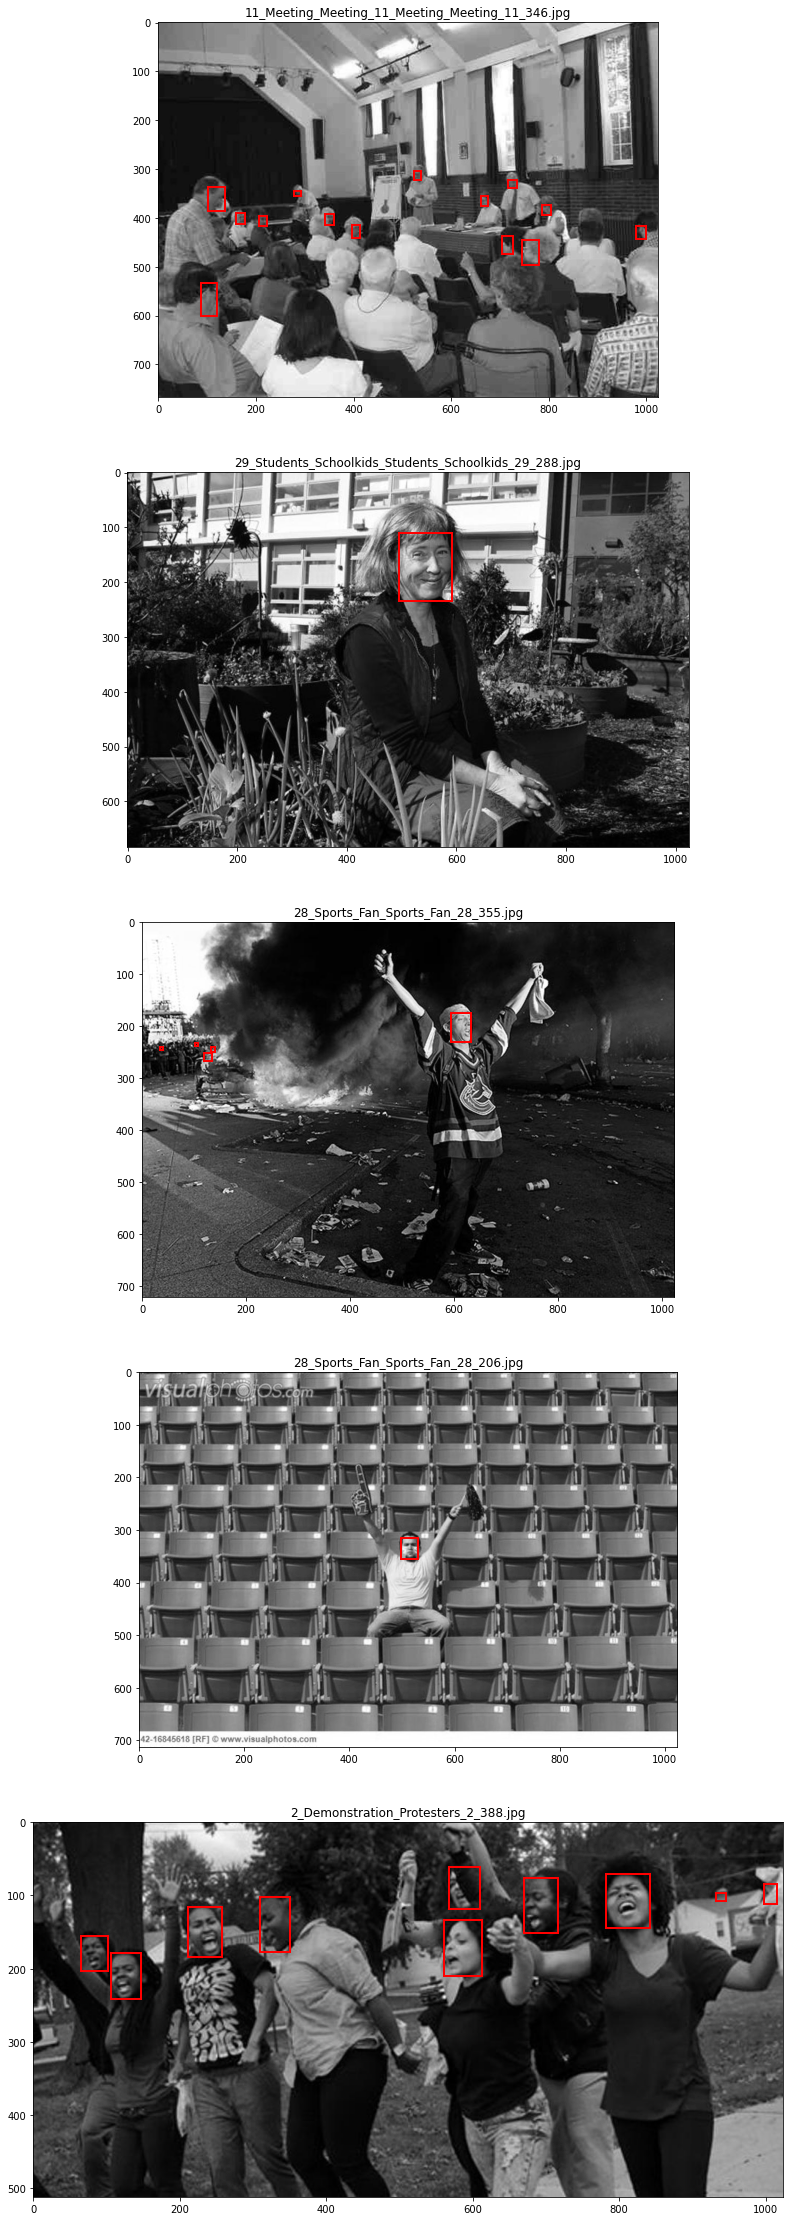

In [14]:
import matplotlib.patches as patches

fig = plt.figure(figsize = (30, 40))
COLUMNS = 1
ROWS = 5
RANDOM_SEED=42

# ax enables access to manipulate each of subplots
ax = []
np.random.seed(RANDOM_SEED)

for i in range(COLUMNS * ROWS):
    rand_num = np.random.randint(0, len(train))

    key = keys_list[rand_num]
    image = train[key]
    # create subplot and append to ax
    ax.append(fig.add_subplot(ROWS, COLUMNS, i + 1))
    for rect in frames[key]:
        rect = patches.Rectangle(
            (rect.x, rect.y), rect.w, rect.h, linewidth=2, edgecolor='r', facecolor='none')
        ax[i].add_patch(rect)
    ax[-1].set_title(key)  # set title
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

plt.show()  # finally, render the plot

#Формируем новые выборки на основе наших изображений

Бежим циклом по всем изображениям из train и вырезаем все лица по следующему правилу:


*   Если лицо есть, то вырезаем его. В качестве не лица берём прямоугольник такого же размера, местоположение - по диагонали от лица, т.е у изображений есть общая точка
*   Если лица нет, то в качестве не лица берём рандомное место. В моём случае это (300, 300, 300, 300)  
  
  
Приведение в одному размеру было таким, чтобы ни один признак не вышел за этот размер.  
Изменение размера шло по принципу Image.LANCZOS. Гугл сказал, что он даёт самое лучшее качество при изменении изображения (вроде там основа от метода k-ближайших соседей)



---

Поскольку используемый xml-файл заточен под размер изображения 20 \* 20 пикселей, то растяжение изображения размера 3 \* 3 качество не улучшит. Поэтому изображения лиц, размеры которых меньше MINSIZE в обучающую выборку не попадут.   




In [15]:
# делаем новые выборки
import math

Faces = namedtuple('Faces', 'img is_face filename rect')
faces = []

MAXSIZE = (25, 25)
MINSIZE = (20, 20)
random_box = (30, 30, 30, 30)

for key in frames:
    for rect in frames[key]:
        if rect == (0, 0, 0, 0):
            img_not_face = train[key].crop(random_box).resize(MAXSIZE, Image.LANCZOS)
            faces.append(Faces(img_not_face, 0, key, Rectangle(random_box[0], random_box[1], random_box[2], random_box[3])))
        elif (rect.w, rect.h) < MINSIZE: 
            continue
        else:
            img_face = train[key].crop(
                (rect.x, rect.y, rect.x + rect.w, rect.y + rect.h)).resize(MAXSIZE, Image.LANCZOS)
            img_not_face = train[key].crop(
                (rect.x + rect.w, rect.y + rect.h, rect.x + 2 * rect.w, rect.y + 2 * rect.h)).resize(MAXSIZE, Image.LANCZOS)
            faces.append(Faces(img_face, 1, key, rect))
            faces.append(Faces(img_not_face, 0, key, Rectangle(rect.x + rect.w, rect.y + rect.h, rect.w, rect.h)))


print(faces[0])
print(len(faces))

Faces(img=<PIL.Image.Image image mode=L size=25x25 at 0x7F135EDA9F98>, is_face=1, filename='0_Parade_marchingband_1_849.jpg', rect=Rectangle(x=449, y=330, w=122, h=149))
75504


# Демонстрация изображений 
Давайте посмотрим пару изображений из новой выборки

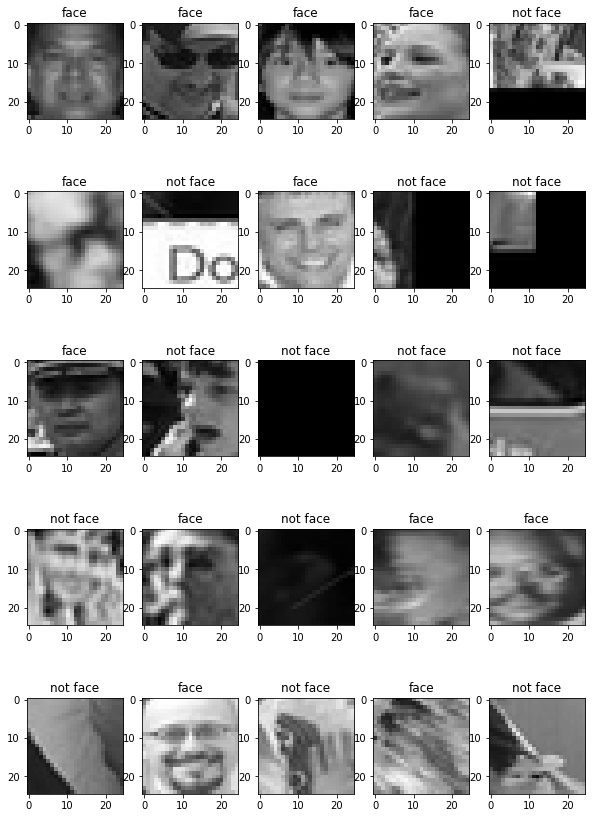

In [16]:
fig = plt.figure(figsize = (10, 15))
COLUMNS = 5
ROWS = 5

# ax enables access to manipulate each of subplots
ax = []
np.random.seed(RANDOM_SEED)

for i in range(COLUMNS * ROWS):
    rand_num = np.random.randint(0, len(faces))
    image = faces[rand_num].img
    # create subplot and append to ax
    ax.append(fig.add_subplot(ROWS, COLUMNS, i+1))
    if faces[rand_num].is_face == 1:
        ax[-1].set_title('face')  # set title
    else:
        ax[-1].set_title('not face')
    plt.imshow(image, cmap = 'gray', vmin = 0, vmax = 255)

plt.show()  # finally, render the plot

#Признаки Хоара

 Признаки я взяла из найденного раннее файла. Я скопировала n-строк, и там оказалось 109 признаков. 

 Формат хранения:
```
<features>  
  <_>
        <rects>
          <_>
            6 4 12 9 -1.</_>
          <_>
            6 7 12 3 3.</_></rects></_>
</features>
```
Представленный выше фрагмент описывает 1 признак Хоара, где прямоугольники задаются так:  
`<_> x1, y1, w, h, weight </_> `  
(верхний левый угол + ширина + высота + вес)  
  
более детальную информацию можно найти здесь:)  
https://api-2d3d-cad.com/viola-jones-method/

In [17]:
class HaarFeature:

    def __init__(self, rect_list):
        self.rect_list = rect_list

    def cacl_feature(self, cumsum_marix):
        f_X = 0
        for rects in self.rect_list:
            if ((rects.w, rects.h) >= MAXSIZE):
                continue
            else:
                f_X += (cumsum_marix[rects.y - 1 + rects.h][rects.x - 1 + rects.w]
                        - cumsum_marix[rects.y - 1][rects.x - 1 + rects.w]
                        - cumsum_marix[rects.y - 1 + rects.h][rects.x - 1]
                        + cumsum_marix[rects.y - 1][rects.x - 1])*rects.weight
        return f_X

In [18]:
# займёмся признаками Хоара
from lxml import etree

h_features = []
HaarRect = namedtuple('HaarRect', 'x y w h weight')

# загрузим xml и распарсим его
with open('/content/drive/My Drive/Курсач/files/my_features.xml') as fobj:
    xml = fobj.read()
    root = etree.fromstring(xml)

    for elems in root.getchildren():
        for rects in elems.getchildren():
            rectangles = []
            for haar_rect in rects.getchildren():
                numbers = haar_rect.text[11:].split(" ")
                rectangles.append(HaarRect(int(numbers[0]), int(numbers[1]), int(
                    numbers[2]), int(numbers[3]), float(numbers[4])))

            h_features.append(HaarFeature(rectangles))
print(h_features[0].rect_list)

[HaarRect(x=6, y=4, w=12, h=9, weight=-1.0), HaarRect(x=6, y=7, w=12, h=3, weight=3.0)]


#Ищем фичи
В этом блоке формируется вектор признаков, который нам так нужен. Каким образом?  
Перемешаем наш массив картинок с лицами и без (на данный момент изображения идут примерно через один)
Далее бежим по новой выборке и для каждого изображения
переводим изображение в интегральное представление.

Один признак Хоара - это 2-3 прямоугольника. Я не знаю, стоит ли учитывать вес, тк в документации https://madebyollin.github.io/opencv-python-docs/#CascadeClassifier-detectMultiScale я нашла конструктор, который использую я. Но там нет ничего про вес. Однако есть конструктор с весами. Только вот я не поняла, там речь идёт про веса прямоугольников или про веса, так называемые sum_stage, которые являются значениями признаков и используются в каскадных классификаторах, чтобы проверять, прошли ли мы порог данного уровня или нет.  
Но при этом есть прямоугольники с положительными весами и с отрицательными, и я так понимаю, это что-то вроде градации на чёрное и белое (тк там где области накладываются, мы суммируем веса, а цвет опред.знаком). Если вес убрать, то нужно искать области, где прямоугольники накладываются друг на друга, поэтому я пока оставила всё с весами и просто суммирую все значения в рамках одного признака, умножив их на соответствующий вес.

In [19]:
# перемешаем выборку, подговим массив ответов, а также поделим всё на train  test
import sklearn.model_selection as sk

random.seed(RANDOM_SEED)
random.shuffle(faces)

y = np.array(list(map(lambda x: int(x.is_face), faces)))
x_train, x_test, y_train, y_test = sk.train_test_split(faces, y, test_size=0.25, random_state=0)


print(x_test[0])

Faces(img=<PIL.Image.Image image mode=L size=25x25 at 0x7F135AA1DD30>, is_face=0, filename='20_Family_Group_Family_Group_20_846.jpg', rect=Rectangle(x=418, y=210, w=39, h=44))


In [20]:
# подготовим изображения для получения признаков на нём и посчитаем признаки
# формируем вектор признаков

def feature_creating(sample, feature_type):
    features = []
    
    for images in sample:
        img = np.array(images.img, 'uint8')
        if feature_type != 'hf':
            features.append(img.flatten())
        else:
            # интегральное представление изображения
            matrix = np.cumsum(np.cumsum(img, axis=0), axis=1)
            f_for_one_img = []
            for fichi in h_features:
               f_for_one_img.append(fichi.cacl_feature(matrix))
            features.append(f_for_one_img)
    return np.array(features)

#Обучаем алгоритм и пробуем его применить

Теперь у нас есть всё, что необходимо для наших экспериментов. А значит мы можем заняться обучением и проверить, насколько хорошо наш алгоритм обучился:)   
Для обучения будем использовать следующие классические методы:


1.   Логистическая регрессия
2.   Решающее дерево
3.   Метод ближайших соседей
4.   Метод опорных векторов

А также для сравнения возьмём ансамбли:

1.   AdaBoost
2.   Случайный лес
3.   Градиентный бустинг.

Вдобавок ко всему вышеперечисленному я предлагаю засечь время (в сек), затраченное в среднем на обучение и предсказание каждым методом, чтобы определить для нашей задачи следующие вещи: 


*   Самый быстрый метод
*   Самый точный метод
*   "Лучший метод за свои деньги" (оптимальное соотношение точность - время работы)

В принципе при желании ещё можно провести анализ занимаемой памяти обученной модели.






#Примечание
Поскольку мы обучаем сразу несколько разных моделей на больших объёмах данных, будем сохранять наши обученные модели и их результаты предсказаний на всякий случай.

In [21]:
#блок с импортом всяких библиотек + создание списков, которые понадобтся ниже
import time
import sklearn.model_selection as sk
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.externals import joblib 
from sklearn.decomposition import PCA

path = '/content/drive/My Drive/Курсач/files/Classificators/'

col_list = ['logreg_', 'tree_', 'knn_', 'svm_', 'randforest_', 'ada_boost_', 'grad_boost_']
#col_list = ['logreg_']

categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']
features_list = ['Haars features', 'Matrix features','Matrix + PCA features']

scaler = StandardScaler()
pca = PCA(n_components = len(h_features))


In [22]:
def training(x_train, y_train, feature_type, time_df, index):
    if feature_type == 'mf_pca':
        x_train_scaled= pca.fit_transform(x_train)
    else:
        x_train_scaled = scaler.fit_transform(x_train)
    C = 1.0

    # берём классификаторы
    from sklearn import svm

    classifiers = [LogisticRegression(random_state = RANDOM_SEED),
                     DecisionTreeClassifier(random_state = RANDOM_SEED),
                     KNeighborsClassifier(n_neighbors = 300),
                     svm.LinearSVC(C=C, max_iter = 10000),
                     RandomForestClassifier(random_state = RANDOM_SEED),
                     AdaBoostClassifier(n_estimators = 100, random_state = RANDOM_SEED),
                     GradientBoostingClassifier(n_estimators = 100, random_state = RANDOM_SEED)]
    #classifiers = [LogisticRegression(random_state = RANDOM_SEED)]

    # обучим классификаторы и сохраним обученные модели
    for i,clf in enumerate(classifiers):
        t0 = time.time()
        clf.fit(x_train_scaled, y_train)
        t = time.time()
        time_df.loc[categories[index]][col_list[i]] += (t - t0)/len(x_train_scaled)
        joblib.dump(clf, os.path.join(path, col_list[i] + feature_type + '.pkl')) 

In [23]:
def prediction(x_test, feature_type, df, time_df, index):
    if feature_type == 'mf_pca':
        x_test_scaled = pca.transform(x_test)
    else:
        x_test_scaled = scaler.transform(x_test)
    
    #загружаем модели
    classifiers = []
    for i, clf_names in enumerate(col_list):
        classifiers.append(joblib.load(os.path.join(path, col_list[i] + feature_type + '.pkl')))

    # проверяем способность прогнозирования после обучения

    for i, clf in enumerate(classifiers):
        t0 = time.time()
        df[col_list[i]] = clf.predict(x_test_scaled)
        t = time.time()
        time_df.loc[categories[index]][col_list[i]] += (t - t0)/len(x_test_scaled)


In [24]:
#создаём признаки
import pandas as pd

samples = [x_train, x_test]
all_features = []


time_df = pd.DataFrame(index = categories, columns = col_list)


for i, f_samples in enumerate(categories):
    parsed_str = f_samples.split("_")
    if  parsed_str[1] == 'train':
        index = 0
    else:
        index = 1
        
    t0 = time.time()
    all_features.append(feature_creating(samples[index], parsed_str[0]))
    t = time.time()
    time_df.loc[categories[i]] = (t - t0)/len(samples[index])

print(len(all_features[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ulong_scalars
  from ipykernel import kernelapp as app


56628


In [25]:
#время в cек после создания признаков
time_df[:]

,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_
hf_train,0.00166064,0.00166064,0.00166064,0.00166064,0.00166064,0.00166064,0.00166064
mf_train,1.32703e-05,1.32703e-05,1.32703e-05,1.32703e-05,1.32703e-05,1.32703e-05,1.32703e-05
pca_train,1.25945e-05,1.25945e-05,1.25945e-05,1.25945e-05,1.25945e-05,1.25945e-05,1.25945e-05
hf_test,0.00165395,0.00165395,0.00165395,0.00165395,0.00165395,0.00165395,0.00165395
mf_test,1.244e-05,1.244e-05,1.244e-05,1.244e-05,1.244e-05,1.244e-05,1.244e-05
pca_test,1.27104e-05,1.27104e-05,1.27104e-05,1.27104e-05,1.27104e-05,1.27104e-05,1.27104e-05


In [26]:
# подготовим данные для финального анализа

haars_df = pd.DataFrame(columns=col_list)
matrix_df = pd.DataFrame(columns=col_list)
matrix_pca_df = pd.DataFrame(columns=col_list)

training(all_features[0], y_train, 'hf', time_df, 0)
prediction(all_features[3], 'hf', haars_df, time_df, 3)
haars_df.insert(0, 'y_test', y_test)

training(all_features[1], y_train, 'mf', time_df, 1)
prediction(all_features[4], 'mf', matrix_df, time_df, 4)
matrix_df.insert(0, 'y_test', y_test)

training(all_features[2], y_train, 'mf_pca', time_df, 2)
prediction(all_features[5], 'mf_pca', matrix_pca_df, time_df, 5)
matrix_pca_df.insert(0, 'y_test', y_test)

#добавим ещё колонки
haars_df['all(1-5)'] = round(haars_df[haars_df.columns[1:len(col_list) + 1]].mean(axis=1))
matrix_df['all(1-5)'] = round(matrix_df[matrix_df.columns[1:len(col_list) + 1]].mean(axis=1))
matrix_pca_df['all(1-5)'] = round(matrix_pca_df[matrix_df.columns[1:len(col_list) + 1]].mean(axis=1))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

In [27]:
#coxpaним датафреймы, чтобы в следующий раз можно было обойтись без обучения
haars_df.to_csv('/content/drive/My Drive/Курсач/files/haars_df.csv') 
matrix_df.to_csv('/content/drive/My Drive/Курсач/files/matrix_df.csv') 
matrix_pca_df.to_csv('/content/drive/My Drive/Курсач/files/matrix_pca_df.csv') 
time_df.to_csv('/content/drive/My Drive/Курсач/files/time_df.csv') 


In [28]:
haars_df[:5]

,y_test,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
0,0,0,0,0,0,0,0,0,0.0
1,0,1,1,1,1,0,0,0,1.0
2,0,0,0,0,0,1,1,1,0.0
3,0,0,1,0,0,0,0,0,0.0
4,1,1,1,1,1,1,1,1,1.0


In [29]:
matrix_df[:5]

,y_test,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
0,0,0,0,1,0,1,1,1,1.0
1,0,1,0,0,1,0,1,0,0.0
2,0,0,0,0,0,1,0,1,0.0
3,0,0,0,0,0,0,0,0,0.0
4,1,1,0,1,1,1,1,1,1.0


In [30]:
matrix_pca_df[:5]

,y_test,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
0,0,0,0,1,0,0,0,0,0.0
1,0,1,0,0,1,0,0,0,0.0
2,0,0,0,0,0,0,0,1,0.0
3,0,0,0,0,0,0,0,0,0.0
4,1,1,1,1,1,1,1,1,1.0


# Результаты
Давайте немного проанализируем, что же у нас получилось.

In [31]:
from sklearn.metrics import accuracy_score
from pandas import read_csv

col_list.append('all(1-5)')

haars_df = read_csv('/content/drive/My Drive/Курсач/files/haars_df.csv', index_col=0)
matrix_df = read_csv('/content/drive/My Drive/Курсач/files/matrix_df.csv', index_col=0)
matrix_pca_df = read_csv('/content/drive/My Drive/Курсач/files/matrix_pca_df.csv', index_col=0)
time_df = read_csv('/content/drive/My Drive/Курсач/files/time_df.csv', index_col=0)
accuracy_df = pd.DataFrame(features_list, index=['1', '2', '3'], columns=['features'])

for i, cols in enumerate(col_list):
    accuracy_df[cols] = [accuracy_score(haars_df['y_test'], haars_df[cols]),accuracy_score(matrix_df['y_test'], matrix_df[cols]),
                         accuracy_score(matrix_pca_df['y_test'], matrix_pca_df[cols])]

accuracy_df[:]

,features,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
1,Haars features,0.725524,0.718743,0.763668,0.726001,0.814579,0.799163,0.805255,0.798156
2,Matrix features,0.749205,0.696652,0.763244,0.748464,0.815904,0.751430,0.786289,0.798527
3,Matrix + PCA features,0.746503,0.695804,0.766423,0.627093,0.805361,0.757947,0.786025,0.798421


In [32]:
time_df[:]

,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_
hf_train,0.001703,0.001839,0.001682,0.012930,0.002617,0.002721,0.004513
mf_train,0.000162,0.000900,0.000161,0.030351,0.002202,0.005264,0.014286
pca_train,0.000056,0.000260,0.000035,0.011052,0.001484,0.002137,0.005547
hf_test,0.001655,0.001655,0.033433,0.001654,0.001683,0.001701,0.001657
mf_test,0.000014,0.000016,0.087068,0.000014,0.000071,0.000199,0.000024
pca_test,0.000013,0.000014,0.015479,0.000013,0.000043,0.000061,0.000016


# Анализ ошибочных детекций
Попробуем организовать вывод изображений, на которых ошибается каждый из алгоритмов по отдельности. А также посмотрим, на чём ошибается наш "коллективный разум".

Также не будем забывать о том, что признаки Хоара плохо работают для детекции лиц, расположенных под углом. Максимальный угол отклонения мб 30°.

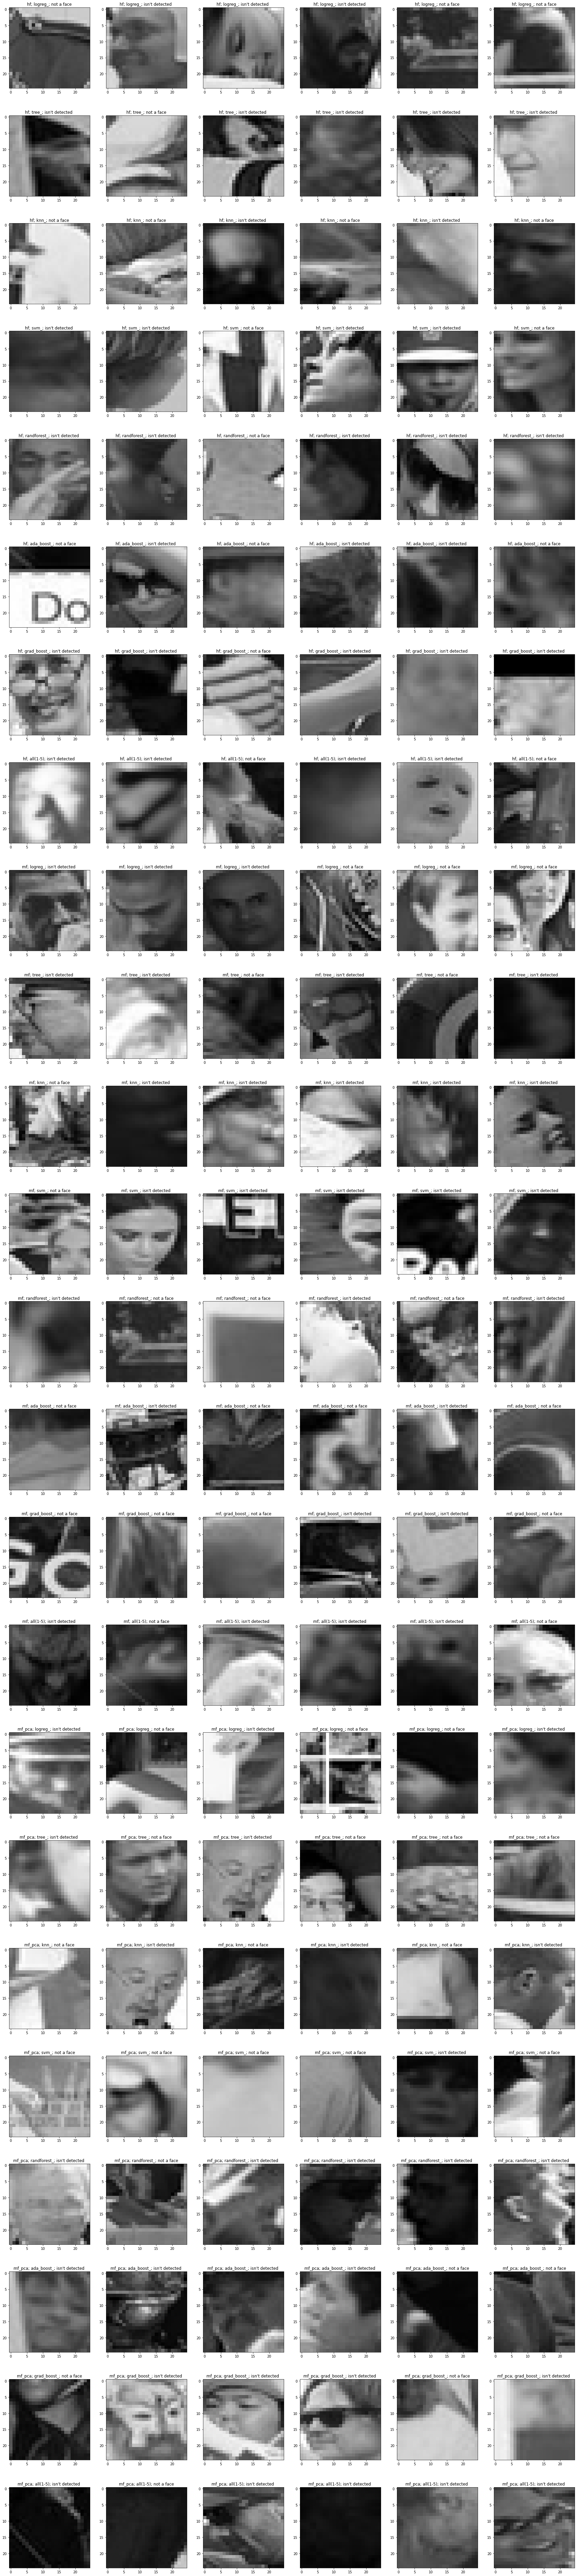

In [33]:
fig = plt.figure(figsize=(30, 140))
COLUMNS = 6
ROWS = 24

# ax enables access to manipulate each of subplots
ax = []
np.random.seed(RANDOM_SEED)
indexes = np.arange(1,144 ,48)

def plotting(dataframe, feature_type, index):

    for i in range(len(col_list)):
        for j in range(COLUMNS):
            rand_num = np.random.randint(0, len(dataframe))

            while dataframe.iloc[rand_num][col_list[i]] == dataframe.iloc[rand_num]['y_test']:
                rand_num = np.random.randint(0, len(dataframe))

            image = x_test[rand_num].img
            ax.append(fig.add_subplot(ROWS, COLUMNS, index))
            index += 1

            if dataframe.iloc[rand_num]['y_test'] == 0:
                ax[-1].set_title(feature_type + '; ' + col_list[i] + '; not a face')
            else:
                ax[-1].set_title(feature_type + '; ' + col_list[i] + '; isn\'t detected ')
    
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        
plotting(haars_df,'hf',indexes[0])
plotting(matrix_df,'mf',indexes[1])
plotting(matrix_pca_df,'mf_pca',indexes[2])


plt.show()  # finally, render the plot